In [56]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
#from nerfunction import *
import re
import emoji
# demoji.download_codes()
import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

%matplotlib inline

In [57]:
# conda install nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/anweshcr7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/anweshcr7/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [58]:
def parse_dataset(fp):
    '''
    Loads the dataset file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt', encoding='utf-8', errors='ignore') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"): # discard first line if it contains metadata
                line = line.rstrip() # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y

In [59]:
data, y_label = parse_dataset('SemEval2018-T3-train-taskA_emoji.txt')
data_df = pd.DataFrame(np.array(data).reshape(3834,1), columns = ['tweet'])
data_df['label'] = np.array(y_label).reshape(3834,1)
data_df.head()

,tweet,label
0,Sweet United Nations video. Just in time for C...,1
1,@mrdahl87 We are rumored to have talked to Erv...,1
2,Hey there! Nice to see you Minnesota/ND Winter...,1
3,3 episodes left I'm dying over here,0
4,"""I can't breathe!"" was chosen as the most nota...",1


In [60]:
# Test model
test_data, test_label = parse_dataset('SemEval2018-T3_gold_test_taskA_emoji.txt')
test_df = pd.DataFrame(np.array(test_data).reshape(784,1), columns = ['tweet'])
test_df['label'] = np.array(test_label).reshape(784,1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
tweet    784 non-null object
label    784 non-null int64
dtypes: int64(1), object(1)
memory usage: 12.4+ KB


In [61]:
# def replace_hashtag_emoji(tweet):
#     tweet = re.sub(r'\B#','', tweet)
#     tweet = emoji.demojize(tweet, delimiters=("", ""))
#     return tweet
# data_df['tweet'] = data_df['tweet'].apply(lambda x: replace_hashtag_emoji(x))

In [62]:
#Feature 1 - number of Named Entity in a tweet using NLTK 

#The below code identiies and counts the named entities (proper nouns) in tweets using nltk tagset
#as nltk tags named entities as a POS, hence the job is to identify NE POS tag


#this function creates an NLTK POS tree of each tokenized sentence

def named_entity_preprocess(data):
    sentences = nltk.sent_tokenize(data)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
    return chunked_sentences

#identify whether feature is NE or not
def extract_entity_names(t):
    entity_names = []
    if hasattr(t, 'label') and t.label():
        if t.label() == 'NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))

    return entity_names

#counting of NE via loop and then normalizing it for each tweet
def named_entity_count(sample):
    named_entity_list = []
      
    for tweet in sample:
        chunked_sentences = named_entity_preprocess(tweet)
        entity_names = []
        for tree in chunked_sentences:
            entity_names.extend(extract_entity_names(tree))
        ne_count = len(entity_names)
        word_count = len(tweet.split())
        ne_score = ne_count / word_count
        named_entity_list.append(ne_score)
    return named_entity_list

#Feature 2 - number of adverbs

def adv_counter(tweets): 
    adv_list = []
    for tweet in tweets:

        tagged = pos_tag(word_tokenize(tweet))
        word_count = 0
        adv_count = 0
        adv_score = 0
        
        for tag in tagged:         

            if (tag[1] == 'RB') or (tag[1] == 'RBS') or (tag[1] == 'RBR'):
                adv_count += 1

            word_count += 1
      
        adv_score = adv_count / word_count
        adv_list.append(adv_score)

    return adv_list

#Feature 3 - number of adjectives

def adj_counter(tweets):
    adj_list = []
     
    for tweet in tweets:
            
        tagged = pos_tag(word_tokenize(tweet))
        word_count = 0
        adj_count = 0
        adj_score = 0
        
        for tag in tagged:
            if (tag[1] == 'JJ') or (tag[1] == 'JJR') or (tag[1] == 'JJS'):
                    adj_count += 1
                
            word_count += 1
        adj_score = adj_count / word_count
        adj_list.append(adj_score)
        
    return adj_list
    

In [63]:
ne_list = named_entity_count(data_df['tweet'])
adj_list = adj_counter(data_df['tweet'])
adv_list = adv_counter(data_df['tweet'])

list_values = np.column_stack(
   [ne_list,adj_list,adv_list, data_df['label']])
list_columns = ['Ne Count', 'Adj Count', 'Adv Count', 'Label']

train_list = pd.DataFrame(list_values, columns=list_columns) #dataframe with the training data features
train_list


,Ne Count,Adj Count,Adv Count,Label
0,0.166667,0.055556,0.055556,1.0
1,0.095238,0.037037,0.037037,1.0
2,0.000000,0.000000,0.000000,1.0
3,0.000000,0.000000,0.125000,0.0
4,0.043478,0.074074,0.074074,1.0
...,...,...,...,...
3829,0.142857,0.125000,0.000000,0.0
3830,0.000000,0.071429,0.142857,0.0
3831,0.000000,0.043478,0.130435,0.0
3832,0.000000,0.000000,0.000000,0.0


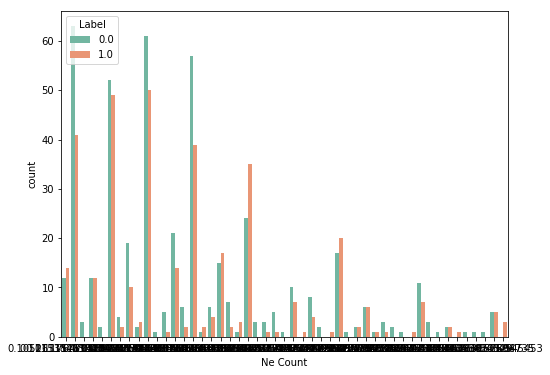

In [64]:
plt.rcParams['figure.figsize'] = (8, 6)
sns.countplot(x='Ne Count', hue='Label', data=train_list[train_list['Ne Count'] > 0.1], palette="Set2");

In [65]:
train_list = train_list.drop(['Label'], axis = 1)

In [66]:
y_train = data_df['label'] #this might be wrong
y_test = test_df['label'] #this might be wrong
test_ne_list = named_entity_count(test_df['tweet'])
test_adj_list = adj_counter(test_df['tweet'])
test_adv_list = adv_counter(test_df['tweet'])

test_list_values = np.column_stack(
   [test_ne_list,test_adj_list,test_adv_list])#, test_df['label']
test_list_columns = ['Ne Count', 'Adj Count', 'Adv Count']# , 'Label'
test_list = pd.DataFrame(test_list_values, columns=test_list_columns) #dataframe with test data parameters
test_list

,Ne Count,Adj Count,Adv Count
0,0.047619,0.068966,0.000000
1,0.000000,0.058824,0.058824
2,0.250000,0.000000,0.000000
3,0.111111,0.000000,0.166667
4,0.000000,0.103448,0.103448
...,...,...,...
779,0.050000,0.000000,0.037037
780,0.080000,0.057143,0.057143
781,0.117647,0.160000,0.000000
782,0.076923,0.050000,0.000000


In [67]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Example of cross-validation
rf = RandomForestClassifier(n_estimators=10)

score = cross_val_score(rf, train_list, y_train, cv=10, scoring = "accuracy")
print('CROSS VALIDATION')
print("Score:", score)
print("Mean:", score.mean())
print("std:", score.std())

CROSS VALIDATION
Score: [0.51168831 0.52083333 0.5        0.55613577 0.50913838 0.50652742
 0.51697128 0.50913838 0.52219321 0.50652742]
Mean: 0.5159153498807546
std: 0.014905310356057721


In [68]:
rf.fit(train_list, y_train)
y_pred = rf.predict(test_list)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.51      0.55       473
           1       0.40      0.50      0.44       311

    accuracy                           0.51       784
   macro avg       0.50      0.50      0.50       784
weighted avg       0.53      0.51      0.51       784



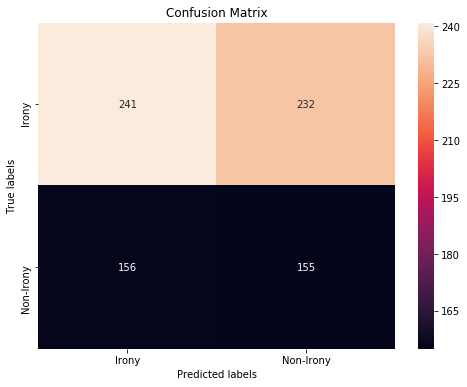

In [69]:
from sklearn.metrics import confusion_matrix

rf_cm = confusion_matrix(y_test, y_pred)
# rf_cm

def plotCM(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Irony', 'Non-Irony']); ax.yaxis.set_ticklabels(['Irony', 'Non-Irony']);
plotCM(rf_cm)

In [70]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn import metrics

gnb = GaussianNB()
score = []
# kfold = KFold(n_splits=10, random_state=1, shuffle=True)
# for train, test in kfold.split(lexical_df):
#     train_tf_idf = tweet_vectorizer.fit_transform(clean_data_df['clean_tweet'][train])
gnb.fit(train_list, y_train)
y_pred = gnb.predict(test_list)
print(metrics.accuracy_score(y_test, y_pred))

0.5612244897959183


In [71]:
from sklearn import svm 
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_



In [72]:
svc_param_selection(train_list, y_train, 5)

{'C': 10, 'gamma': 1}

In [73]:
clf = svm.SVC(C=1, gamma = 0.1, kernel = 'rbf')
clf.fit(train_list, y_train)
y_pred = clf.predict(test_list)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits = 4))

0.5459183673469388
              precision    recall  f1-score   support

           0     0.6275    0.6089    0.6180       473
           1     0.4308    0.4502    0.4403       311

    accuracy                         0.5459       784
   macro avg     0.5291    0.5295    0.5291       784
weighted avg     0.5494    0.5459    0.5475       784



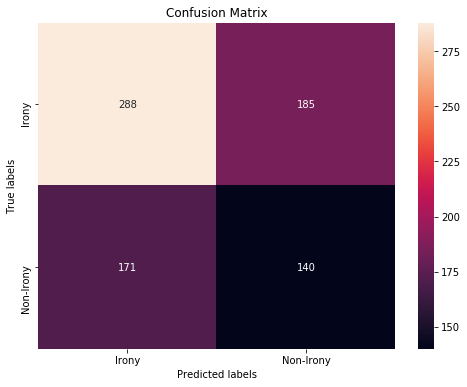

In [75]:
svm_cm = confusion_matrix(y_test, y_pred)
plotCM(svm_cm)

In [76]:
feat_labels = list(train_list)
for feature in zip(feat_labels, rf.feature_importances_):
    print(feature)

('Ne Count', 0.3166778154128401)
('Adj Count', 0.4183127507617771)
('Adv Count', 0.2650094338253829)
